In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
import xarray as xr
import xbudget
import xwmb
from CM4Xutils import *

### Load coarsened zarr data

In [3]:
local_path_to_budgets_zarr = "../../../codedev/CM4Xutils/data/coarsened/CM4Xp25_budgets_sigma2_2000-2004.zarr"

ds = xr.open_zarr(local_path_to_budgets_zarr)
grid = ds_to_grid(ds.fillna(0.))

Inferring Z grid coordinate: density `sigma2`


### Evaluate density binning of surface heat fluxes

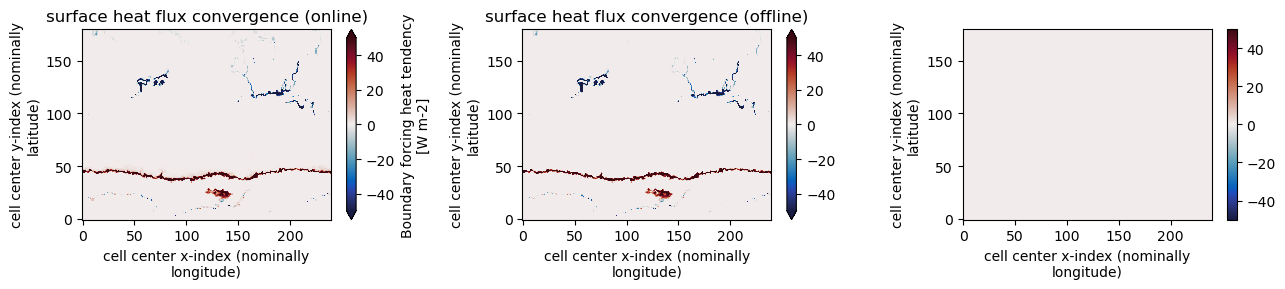

In [4]:
import matplotlib.pyplot as plt
import cmocean.cm as cmo

plt.figure(figsize=(13, 3))
plt.subplot(1,3,1)
(ds.boundary_forcing_heat_tendency.fillna(0.)).isel(exp=0, time=0).sel(sigma2_l=35.75, method="nearest").plot(vmin=-50, vmax=50, cmap=cmo.balance)
plt.title("surface heat flux convergence (online)")

plt.subplot(1,3,2)
((ds.hflso + ds.hfsso + ds.rlntds + ds.rsdoabsorb + ds.heat_content_surfwater).fillna(0.)).isel(exp=0, time=0).sel(sigma2_l=35.75, method="nearest").plot(vmin=-50, vmax=50, cmap=cmo.balance)
plt.title("surface heat flux convergence (offline)")

plt.subplot(1,3,3)
((ds.boundary_forcing_heat_tendency - (ds.hflso + ds.hfsso + ds.rlntds + ds.rsdoabsorb + ds.heat_content_surfwater)).fillna(0.)).isel(exp=0, time=0).sel(sigma2_l=35.75, method="nearest").plot(vmin=-50, vmax=50, cmap=cmo.balance)
plt.title("")
plt.tight_layout()

### Compute water mass budgets

In [5]:
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)

    budgets_dict = xbudget.load_preset_budget(model="MOM6_3Donly")
    xbudget.collect_budgets(grid, budgets_dict)
    
    wmb = xwmb.WaterMassBudget(
        grid,
        budgets_dict,
        method="xgcm"
    )
    wmb.mass_budget("sigma2", greater_than=True, default_bins=False, integrate=True, along_section=False)
    wmt = wmb.wmt

In [6]:
%%time
wmt_mean = (wmt.sel(exp="forced").mean("time")/1035*1e-6)
wmt_mean.load()

CPU times: user 8min 46s, sys: 4min 1s, total: 12min 47s
Wall time: 1min 8s


<xarray.Dataset> Size: 2MB
Dimensions:                                         (sigma2_l_target: 74,
                                                     sigma2_i_target: 75,
                                                     time_bounds: 61, yh: 180,
                                                     xh: 240)
Coordinates: (12/13)
    exp                                             <U6 24B 'forced'
  * sigma2_l_target                                 (sigma2_l_target) float64 592B ...
  * sigma2_i_target                                 (sigma2_i_target) float64 600B ...
  * time_bounds                                     (time_bounds) object 488B ...
    areacello                                       (yh, xh) float64 346kB 1....
    deptho                                          (yh, xh) float32 173kB 0....
    ...                                              ...
    geolon                                          (yh, xh) float64 346kB -2...
    lat                                             (yh, xh) float64 346kB -7...
    lon                                             (yh, xh) float64 346kB -2...
    wet                                             (yh, xh) float32 173kB 0....
  * xh                                              (xh) int64 2kB 0 1 ... 239
  * yh                                              (yh) int64 1kB 0 1 ... 179
Data variables: (12/39)
    diffusion_heat                                  (sigma2_l_target) float64 592B ...
    diffusion_salt                                  (sigma2_l_target) float64 592B ...
    bottom_flux_heat                                (sigma2_l_target) float64 592B ...
    surface_ocean_flux_advective_negative_lhs_heat  (sigma2_l_target) float64 592B ...
    surface_ocean_flux_advective_negative_lhs_salt  (sigma2_l_target) float64 592B ...
    surface_exchange_flux_heat                      (sigma2_l_target) float64 592B ...
    ...                                              ...
    mass_tendency                                   (sigma2_l_target) float64 592B ...
    dt                                              float64 8B 0.002539
    realized_transformation                         (sigma2_l_target) float64 592B ...
    spurious_numerical_mixing                       (sigma2_l_target) float64 592B ...
    advection_plus_BC                               (sigma2_l_target) float64 592B ...
    diabatic_advection                              (sigma2_l_target) float64 592B ...

In [7]:
def stairs(wmt, var, units="kg", **kwargs):
    da = wmt[var]
    coord = wmt[[c for c in wmt.coords if "l_target" in c][0]]
    coord_bounds = wmt[[c for c in wmt.coords if "i_target" in c][0]]
    l = plt.stairs(da, coord_bounds, **kwargs, orientation="horizontal")
    plt.xlabel(f"mean transformation rate [{units}]")
    return l

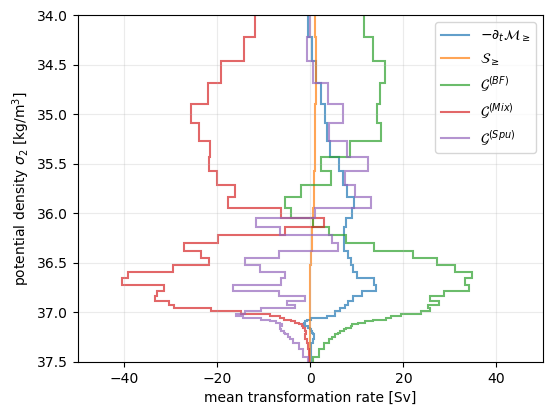

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4.5))

kwargs = {"units":"Sv", "alpha":0.7, "lw":1.5}

stairs(-wmt_mean, 'mass_tendency',             label=r"$-\partial_{t} \mathcal{M}_{\geq}$",**kwargs)
stairs( wmt_mean, 'mass_source',               label=r"$\mathcal{S}_{\geq}$",            **kwargs)
stairs( wmt_mean, 'boundary_fluxes',           label=r"$\mathcal{G}^{(BF)}$",      **kwargs)
stairs( wmt_mean, 'diffusion',                 label=r"$\mathcal{G}^{(Mix)}$",     **kwargs)
stairs( wmt_mean, 'spurious_numerical_mixing', label=r"$\mathcal{G}^{(Spu)}$", **kwargs)

plt.legend(loc="upper right")
plt.grid(True, alpha=0.25)
plt.ylabel(r"potential density $\sigma_{2}$ [kg/m$^{3}$]");
plt.ylim(37.5, 34.0);
plt.xlim(-50, 50);